# Optimizing DLS
Optimize the number of rotation to demodulate for subsets.

In [1]:
from tools.dls import *
import time 
from matplotlib.ticker import ScalarFormatter

### run 11

In [2]:
%%time 

# read run 11 data files
data_df = quick_read(11)
data_na = data_df.values

CPU times: user 1min 58s, sys: 12.6 s, total: 2min 11s
Wall time: 2min 5s


### Test performance for each number of rotation
We use *C* to store the output coefficients for each test.
*C* is a list contains two dictionary (one for the value of each coefficient, one for std)
    

In [ ]:
# initalization
rot_list = [5, 10, 20, 50, 100, 1000, 10000]
N_r = len(rot_list)
C = [None] * N_r  # store coefficient for each sub_rot
T = [None] * N_r
w_s = 2 * np.pi / (23*3600 + 56*60 + 4)  # sidereal frequency

# for every subset_rot
for i in range(N_r):
    
    start_time = time.time()
    
    subset_rot = rot_list[i]
    print(str(i+1) + '/' + str(N_r) + '; subset_rot = {}'.format(subset_rot))
    
    param_df = DLS1(data_na, subset_rot)
    C[i] = DLS2(param_df, w_s)  
    
    end_time = time.time()
    
    T[i] = end_time - start_time
    print('Time cost: ' + str(T[i]) + 's\n')


1/7; subset_rot = 5


# Write & Read
Write result in a file and read it back.

## Writing
writing the SME coefficient (their value and std) to the two txt files. Also the parameters (subset rotation number and elapsed time) to another txt file.

In [6]:
# reading results into several DataFrame
params_df = pd.DataFrame({'N_r': rot_list, 'Time (s)': T})
values_df = pd.DataFrame()
sigmas_df = pd.DataFrame()

N = len(rot_list)

for i in range(N):
    value_df = pd.DataFrame(C[i][0], index=[str(i)])
    sigma_df = pd.DataFrame(C[i][1], index=[str(i)])
    
    values_df = pd.concat([values_df, value_df])
    sigmas_df = pd.concat([sigmas_df, sigma_df])
    
# writing DataFrames
location = './Data/DLS_Optimization/'
params_filename = 'parameters.txt'
values_filename = 'EMScoefficientValues.txt'
sigmas_filename = 'EMScoefficientSigmas.txt'

params_df.to_csv(location + params_filename, index_label='Index')
values_df.to_csv(location + values_filename, index_label='Index')
sigmas_df.to_csv(location + sigmas_filename, index_label='Index')
    


## Reading
read the file just written

In [3]:
location = './Data/DLS_Optimization/'
params_filename = 'parameters.txt'
values_filename = 'EMScoefficientValues.txt'
sigmas_filename = 'EMScoefficientSigmas.txt'

# read parameters
params_df = pd.read_csv(location + params_filename, index_col='Index')
rot_list = params_df['N_r']
T = params_df['Time (s)']

# read value and sigmas as dictionary
values_df = pd.read_csv(location + values_filename, index_col = 'Index')
sigmas_df = pd.read_csv(location + sigmas_filename, index_col = 'Index')

# number of samples
N = len(rot_list)

# Visualizing result
## Coefficient index table
|Coefficient|$c^T_Q$|$c^T_X$|$c^T_Y$|$c^T_Z$|$c^T_M$|$c^T_\_$|
|:-:|
|*index*|0|1|2|3|4|5|


In [20]:
index = 4
co_dict = {'0': 'c_T_Q', '1': 'c_T_X','2': 'c_T_Y','3': 'c_T_Z','4': 'c_T_M','5': 'c_T_u'}  # for selecting coefficient in another dictionary
co_index = co_dict[str(index)]
ylabel_dict = {'0': '$c^T_Q$', '1': '$c^T_X$','2': '$c^T_Y$','3': '$c^T_Z$','4': '$c^T_M$','5': '$c^T_\_$'}  # for displaying on y label
co_ylabel = ylabel_dict[str(index)]

co_value = values_df[co_index].values
co_sigma = sigmas_df[co_index].values

# Plotting

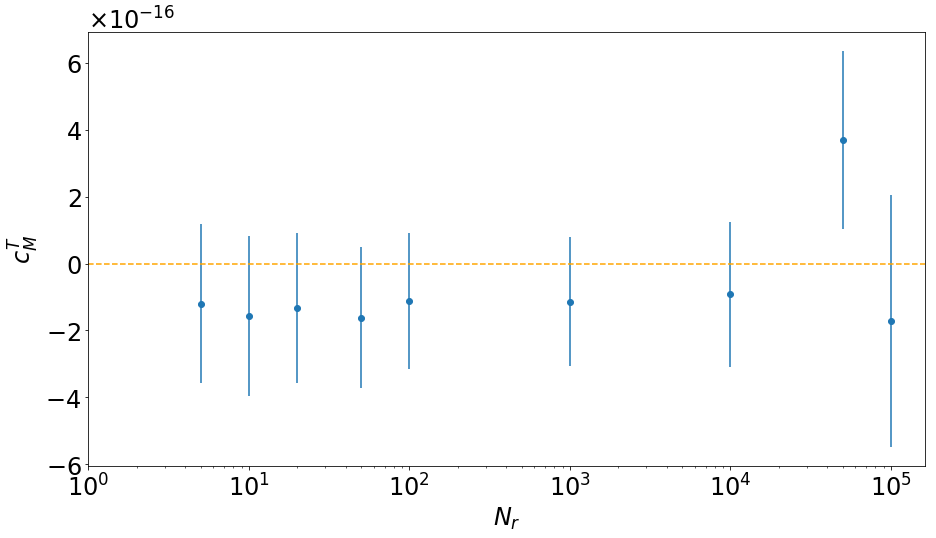

In [21]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_xscale("log", nonposx='clip')
ax.errorbar(rot_list, co_value, yerr=co_sigma, fmt='o')
ax.axhline(0, linestyle='--',color='orange')
ax.set_xlabel('$N_r$', fontsize=24)
ax.set_ylabel(co_ylabel, fontsize=24)
ax.tick_params(labelsize=24)
ax.set_xlim(left=1)

# changing the format of the offset
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))  
t = ax.yaxis.get_offset_text()
t.set_size(24)

plt.show()

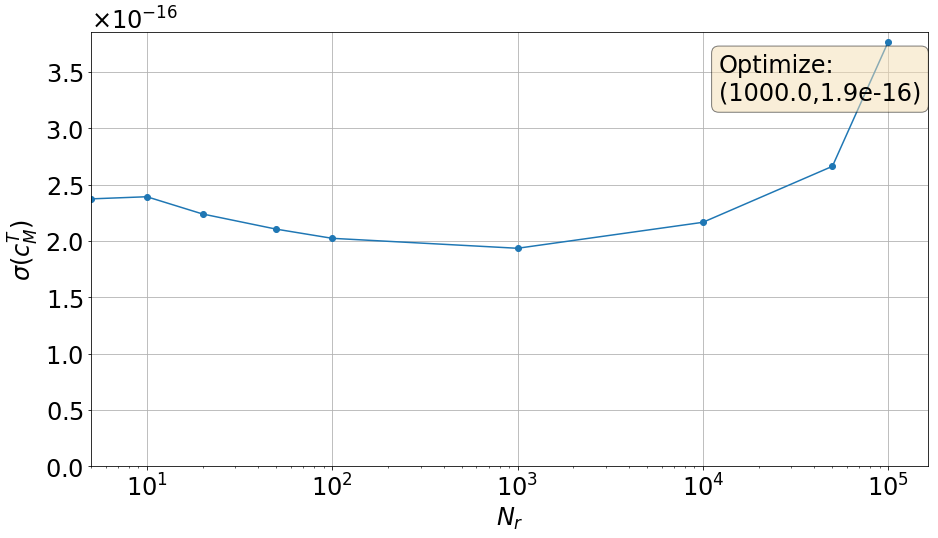

In [22]:
# calculate the min position
y_min = np.min(co_sigma)
y_min_disp = str(round(y_min,17))
x_min_index = np.argmin(co_sigma)
x_min = rot_list[x_min_index]

# plotting
fig, ax = plt.subplots(figsize=(15,8))
ax.semilogx(rot_list, co_sigma, '-o')

# add text
textstr = 'Optimize:\n' + '(' + str(x_min) + ',' + str(y_min_disp) + ')'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=24,
        verticalalignment='top', bbox=props)

ax.set_xlabel('$N_r$', fontsize=24)
ax.set_ylabel('$\sigma$('+co_ylabel+')', fontsize=24)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.tick_params(labelsize=24)

# changing the format of the offset
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))  
t = ax.yaxis.get_offset_text()
t.set_size(24)

plt.grid()
plt.show()

## Time elapse

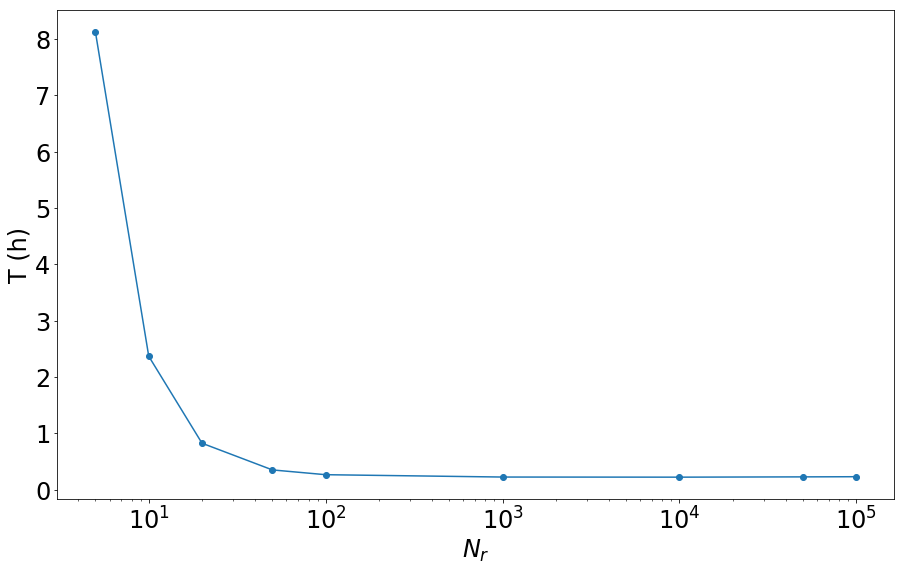

In [13]:
T_h = [t/3600 for t in T]

fig, ax = plt.subplots(figsize=(15,9))
ax.semilogx(rot_list, T_h, '-o')
ax.set_xlabel('$N_r$', fontsize=24)
ax.set_ylabel('T (h)', fontsize=24)
ax.tick_params(labelsize=24)

plt.show()